# Challenge-level descriptives

Social comparison effects get even stronger with relative scoring so we would expect more competition, more inequality in outcomes, and less efficiency (contestants putting more effort than they should) even though in both cases the leaderboard looks the same and (hopefully) the prize structure is similar.

In [1]:
%matplotlib inline

import os
import sys
# Include directory for own modules
module_path = os.path.abspath(os.path.join('../../code/own_modules'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import data_import
import myplots
import myutils
import importlib as imp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import my_time_series as ts
import seaborn as sns
import math
from random import sample

DATADIR = '../../data/'

## Prepare data for CEM

In [2]:
def get_cem_data():
    challenge_data = pd.read_csv(DATADIR + 'contestdatasetfull.csv')

    # There is one problem that has 111 challenges, exclude it
    #print(sorted(challenge_data['NumRounds'].values))
    challenge_data = challenge_data[challenge_data['NumRounds']<50]

    cat_vars = ['machine_learning', 'improve', 'target',
              'task_type', 'submission_type', 'scoring_type', 
              'provisional_testing', 'system_vs_provisional',
              'prize_nonmonetary', 'prize_threshold']
    for i in cat_vars:
        challenge_data[i] = challenge_data[i].astype('category')
        challenge_data[i] = challenge_data[i].cat.rename_categories(lambda x: x.lstrip('12345678-'))
    challenge_data['contestant_registrant_ratio'] = challenge_data['Contestants'] / challenge_data['Registrants']
    challenge_data['average_experience'] = challenge_data['Experience'] / challenge_data['Contestants']

    time_data = pd.read_csv(DATADIR + 'roundpositivetiming.csv')
    challenge_data = challenge_data.merge(time_data, on=['ProblemID', 'RoundID'], how='left')
    challenge_data['duration'] = np.ceil((challenge_data['LastPosSubTime'] - challenge_data['FirstSubmissionTime'])/3600)
    
    challenge_data = challenge_data[['ProblemID', 'RoundID', 'PS_Link', 'Contestants', 
                'contestant_registrant_ratio', 'NumRounds', 
                'FirstSubmissionTime', 'LastPosSubTime', 'Experience',
                'engagement_barrier', 'scoring_complexity', 'prize_pool',
                'prize_number', 'average_experience', 'duration', 
                'machine_learning', 'improve', 'target',
                'task_type', 'submission_type', 'scoring_type', 
                'provisional_testing', 'system_vs_provisional',
                'prize_nonmonetary', 'prize_threshold']]
    challenge_data.columns = ['problem_id', 'round_id', 'link', 'num_contestants', 
                'contestant_registrant_ratio', 'num_rounds', 
                'first_submission_time', 'last_submission_time', 'experience',
                'engagement_barrier', 'scoring_complexity', 'prize_pool',
                'prize_number', 'average_experience', 'duration', 
                'machine_learning', 'improve', 'target',
                'task_type', 'submission_type', 'scoring_type', 
                'provisional_testing', 'system_vs_provisional',
                'prize_nonmonetary', 'prize_threshold']

    return challenge_data



cat_vars = ['machine_learning', 'improve', 'target',
              'task_type', 'submission_type', 'scoring_type', 
              'provisional_testing', 'system_vs_provisional',
              'prize_nonmonetary', 'prize_threshold']
challenge_data = get_cem_data()
print('Number of unique problems:', len(challenge_data['problem_id'].unique()))
print('Number of rounds:', len(challenge_data['round_id'].unique()))

num_vars = {'num_contestants': range(0, challenge_data['num_contestants'].max()+50, 50), 
            'contestant_registrant_ratio': np.arange(0, 1.01, 0.05),
            'engagement_barrier': np.arange(1, 5.1, 0.5), 
            'scoring_complexity': np.arange(1, 5.1, 0.5), 
            'prize_pool': range(0, int(challenge_data['prize_pool'].max())+5000, 5000),
            'prize_number': range(0, int(challenge_data['prize_number'].max())+1, 1), 
            'num_rounds': range(1, int(challenge_data['num_rounds'].max())+1, 1),
            'first_submission_time': None,  
            'average_experience': np.arange(0, challenge_data['average_experience'].max()+10, 10),
            'duration': range(1, int(challenge_data['duration'].max())+72, 72)}

challenge_data.to_csv('challenges_cem.csv', index=False)

Number of unique problems: 214
Number of rounds: 256


## Plot variable distributions

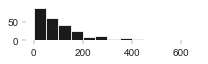

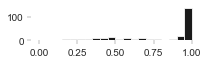

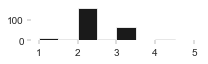

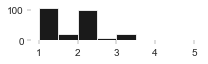

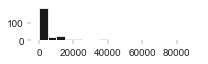

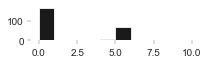

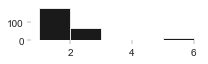

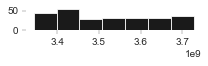

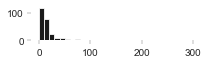

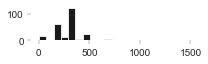

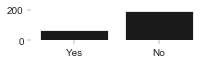

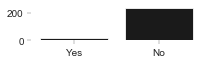

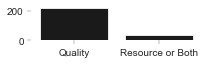

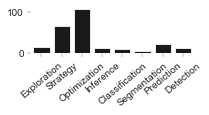

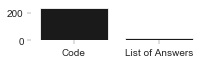

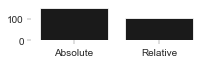

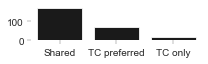

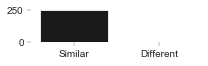

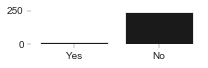

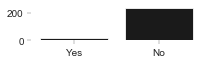

In [3]:
sns.set(style="ticks", palette="colorblind", context='paper', 
        rc={"lines.linewidth": 0.6, 'axes.linewidth':0.3, 
            'xtick.major.size': 4, 'xtick.major.width':0.3, 'xtick.labelsize': 10,
            'ytick.major.size': 4, 'ytick.major.width':0.3, 'ytick.labelsize': 10,
            'legend.fontsize': 10, 'font.size': 10})

# Save distribution plots to include in descriptives table
for i in num_vars:
    f = plt.figure(figsize = (3, 1))
    sns.distplot(challenge_data[i], kde=False, color='k', \
    sns.despine(left=True, bottom=True)
    plt.xlabel('')
    plt.tight_layout()
    plt.savefig('plots/'+i+'.pdf', type='pdf')

# scoring_complexity roughly varies from strongly agree to agree, so hard to 
#      claim this difference matters
# Contests are evenly distributed across time so no need to control for this
# average_experience captures more meaningful variability than Experience
'''f = plt.figure(figsize = (12, 4))
sns.scatterplot(challenge_data['num_contestants'], challenge_data['experience'])

f = plt.figure(figsize = (12, 4))
sns.scatterplot(challenge_data['first_submission_time'], challenge_data['experience'])

f = plt.figure(figsize = (12, 4))
sns.scatterplot(challenge_data['num_contestants'], challenge_data['average_experience'])

f = plt.figure(figsize = (12, 4))
sns.scatterplot(challenge_data['first_submission_time'], challenge_data['average_experience'])'''

# Save count plots to include in descriptives table
for i in cat_vars:
    if i=='task_type':
        f = plt.figure(figsize = (3, 1.7))
    else:
        f = plt.figure(figsize = (3, 1))
    clrs = ['k' for x in range(8)]
    g = sns.countplot(x = i, data = challenge_data, palette=clrs)
    sns.despine(left=True, bottom=True)
    if i=='task_type':
        g.set_xticklabels(g.get_xticklabels(), rotation=40)
        #g.set_xticklabels(['Exploration', '\nStrategy', '\n\nOptimization', 'Inference', '\nClassification', '\n\nSegmentation', 'Prediction', '\nDetection'])
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig('plots/'+i+'.pdf', type='pdf')



## Check if differences in covariates are orthogonal to scoring type

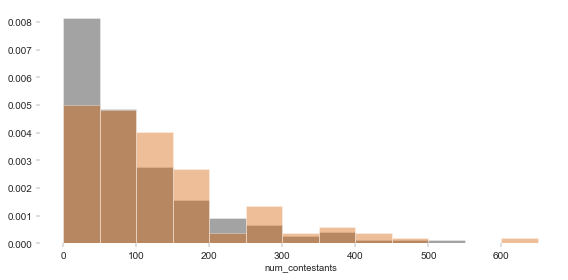

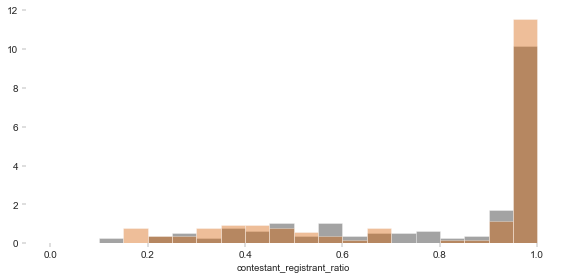

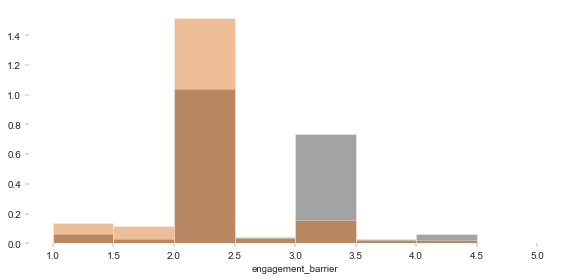

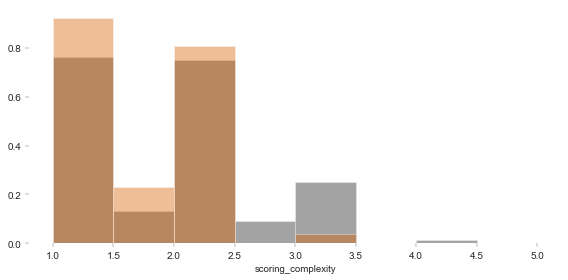

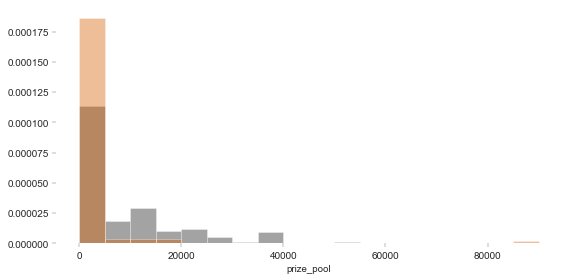

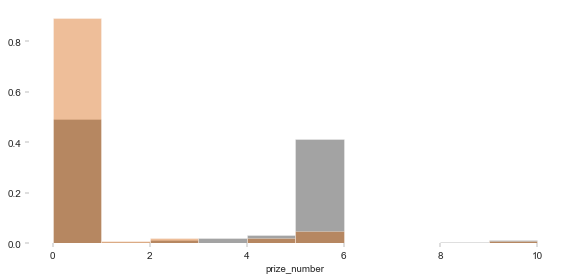

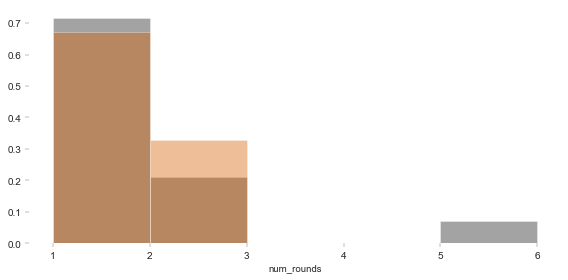

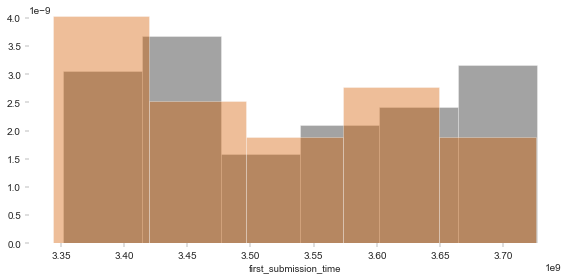

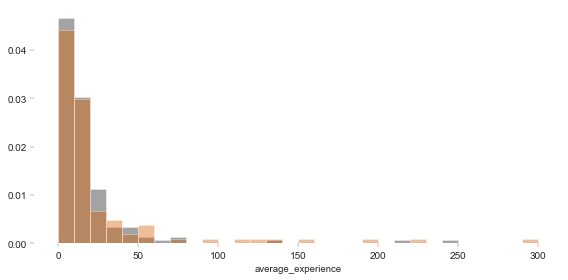

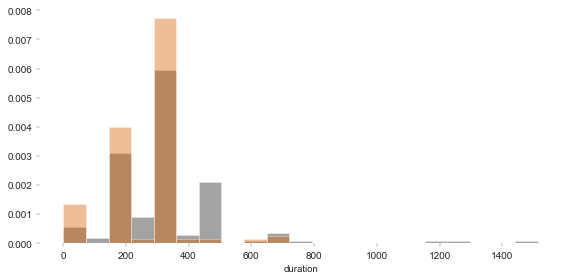

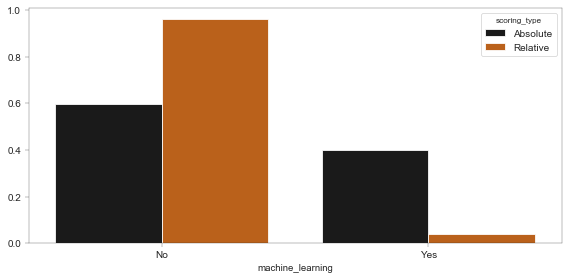

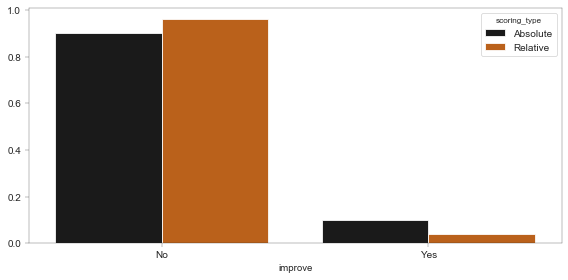

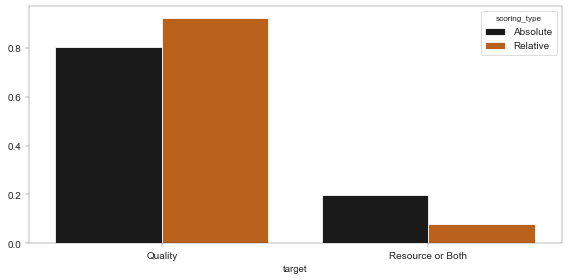

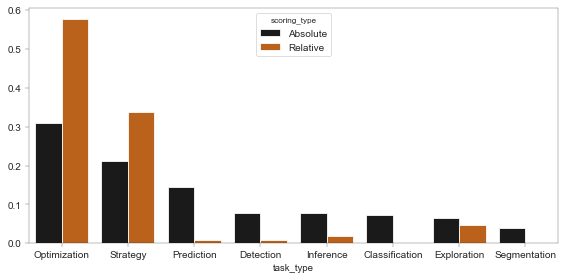

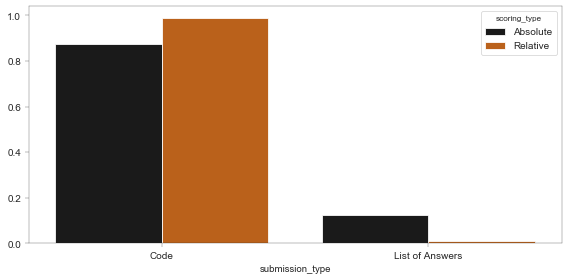

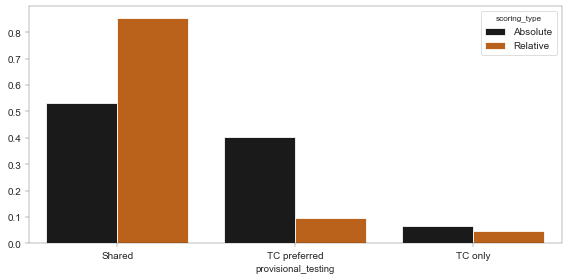

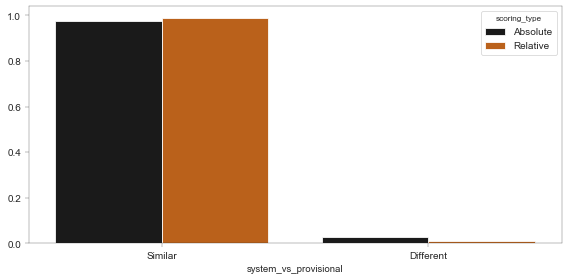

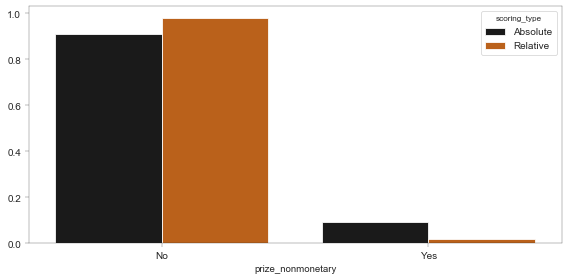

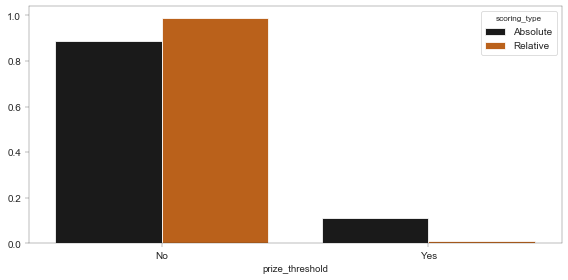

In [4]:
for i in num_vars:
    f = plt.figure(figsize = (8, 4))
    sns.distplot(challenge_data[challenge_data['scoring_type']=='Absolute'][i], kde=False, color='k', \
                 bins = num_vars[i], norm_hist=True)
    sns.distplot(challenge_data[challenge_data['scoring_type']=='Relative'][i], kde=False, color='r', \
                 bins = num_vars[i], norm_hist=True)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    
for i in [j for j in cat_vars if j!='scoring_type']:
    f = plt.figure(figsize = (8, 4))
    clrs = ['k', 'r']
    count_data = (challenge_data.groupby(['scoring_type'])[i]
                     .value_counts(normalize=True)
                     .rename('density')
                     .reset_index())
    sns.barplot(x = i, y = 'density', hue = 'scoring_type', data = count_data, palette=clrs)

    
    #sns.countplot(x = i, data = challenge_data, hue = 'scoring_type', palette=clrs)
    #sns.despine(left=True, bottom=True)
    plt.ylabel('')
    plt.tight_layout()

In [6]:
print("Sample Absolute challenges:")
for i in sample(challenge_data.loc[challenge_data.scoring_type == 'Absolute', 'link'].tolist(), 3):
    print(i)
print("\nSample Relative challenges:")
for i in sample(challenge_data.loc[challenge_data.scoring_type == 'Relative', 'link'].tolist(), 3):
    print(i)

Sample Absolute challenges:
https://community.topcoder.com/longcontest/?module=ViewProblemStatement&rd=16529&pm=13949
https://community.topcoder.com/longcontest/?module=ViewProblemStatement&rd=15649&pm=12544
https://community.topcoder.com/longcontest/?module=ViewProblemStatement&rd=16829&pm=14399

Sample Relative challenges:
https://community.topcoder.com/longcontest/?module=ViewProblemStatement&rd=10757&pm=7542
https://community.topcoder.com/longcontest/?module=ViewProblemStatement&rd=13795&pm=10410
https://community.topcoder.com/longcontest/?module=ViewProblemStatement&rd=15983&pm=13189


#### Examples absolute scoring:
> Your score for each test case will be the square of the fraction of characters that you decoded correctly (not including those whose answers are given to you). Your overall score will be the sum of your individual scores, times 100.

> Your score is calculated by determining how many pixels of your returned image exactly match the pixels of the actual hidden image. Since the return may have more or less rows or columns than the actual image, your returned image will be compared against the actual image, adjusted by each possible offset in the x and y directions, taking the best value. Then, letting best = #pixels matched, your score is calculated as best^2 / yourArea / actualArea. Your final score will be the sum of your score from each individual test case.

> For each test case, your input will be evaluated on a set of 10,000 missions, randomly selected from a corpus of 200,000. The average number of evacuations per mission must be no more than the input P. Thus the total number of evacuations summed over all missions must be no more than P*10000. Given that, your score will be 1000 / (mass + C * volume), where C is an input parameter. If the evacuations rate exceeds P, your score will be 0 for that test case. Your overall score will be the sum of your individual scores.

#### Example relative scoring:
> After each call of rotateSquare it is checked whether there exists an active contact on the left connected with an active contact on the right. If such pair of contacts is found, the simulation stops, and the score for a test case is 
(number of active contacts on the left which are connected with at least one active contact on the right) + (number of active contacts on the right which are connected with at least one active contact on the left) 
divided by the number of moves made. 
<strong>Your overall score will be the sum of your individual scores, divided by the greatest score achieved by anyone for that test case.</strong>

> Scoring is based on crossings, total length, total size, and number of segments. Each crossing of two segments from different hyperedges will incur a cost of C. Each unit of length in segments will incur a cost of L. Each segment will incur a cost of S. Finally the perimeter of the bounding box around your drawing will incur a cost of P per unit. <strong>For each test case, your score will be BEST/YOU, where BEST is the lowest cost incurred on a test case.</strong> Invalid returns or program crashes will be treated as a cost of infinity, yielding 0 points for the test case.

> Your raw score for each test case will be the amount of unused space in the box. (If your solution produces an error, makes an invalid move, etc, then all spaces are considered unused.) The total unused spaces over all cases will be summed for each submission. <strong>Your final score will be 1000 * best_sum / your_sum.</strong>

## What to do next?
In our sample, it seems that <strong>experienced and high performing coders self select into relative challenges</strong>. Further, it seems that <strong>relative challenges have a higher engagement barrier than absolute challenges </strong> and that they <strong>have a more complex scoring procedure</strong>. As the scoring type, i.e. relative vs absolute, is not communicated to the participants, in fact it isn't even known a priori, there must be another factor explaining this self selection, such as difficulty level. Therfore, our best bet is to compare <strong>absolute and relative challenges while keeping controls constant</strong>.

# II. Controlling for Confounders
## 1. Challenges - Selection on Observables using matching
For a lack of an intuitively feasible way to control for unobservables (such as randomized experiment, or natural experiment), we need to control for observable confounders. Two ways come to mind to achieve this, multivariate regression and matching. As, multivariate regression makes more assumptions, particularly about the functional form, I choose matching as the more conservative, non-parametric, method to start with.

#### Possible confounders:
- Experience
- Previous ranks
- Length of challenge
- Number of participants
- engagement barrier
- prize structure

## 2. The matching procedure: Coarsened Exact Matching (CEM)

### 2.1 Why CEM?
- <strong>Why matching?</strong> We want to use matching mainly <strong>to reduce bias</strong>, because as Rubin (2006) argues:
> "First, since it is generally not wise to obtain a very precise estimate of a drastically wrong quantity, theinvestigator should be more concerned about having an estimate with small bias than one with small variance. Second, since in many observational studies the sample sizes are sufficiently large that sampling variances of estimators will be small, the sensitivity of estimators to biases is the dominant source of uncertainty."
- <strong>Other matching estimators</strong>, like propensity score matching or euclidean distance matching, belong to the class of "equal percent bias reducing"(EPBR). Those decrease the variance as a primary property and <strong>only decrease bias as a secondary property and only sometimes</strong>. King et al. (2016) state:
> "[EPBR] does not guarantee any level of imbalance reduction in any given data set; its propertiesonly hold on average across samples and even then only by assuming a set of normally unverifiable assumptions about the data generation process. In any application, a single use of these techniques can increase imbalance and model dependence by any amount."
- Therefore King et al. (2011) introduce <strong>a new class</strong>, "monotonoic imbalance bounding" (MIB) methods, to which CEM belongs, <strong>that primarily addresses the issue of imbalance/bias reduction</strong>. According to King et al. (2016):
> "CEM  and  other  MIB methods invert the process and thus guarantee that the imbalance between the matched treated and control groups will not be larger than the ex ante user choice. This level is chosen by the user on the basis of specific, intuitive substantive information, which they demonstrably have. [...] With MIB methods, improvements in the bound on balance for one covariate can be studied and improved in isolation as it will have no effect on the maximum imbalance of each of the other covariates."

### 2.2 How does CEM work?
1. <strong>Temporarily coarsen X</strong> to the discretion of the analyst (e.g. in our case the variable Prizes to no prizes | low prizes | high prizes)
2. <strong>Apply exact matching</strong> to the coarsened X, C(X) 
    - Sort observations into strata, each with unique values of C(X)
    - Prune any stratum with 0 treated and 0 controls<br>
3. <strong>Pass on original (uncoarsened) units</strong> except those pruned
4. <strong>Estimate and weight</strong> controls in each stratum to equal treateds

<strong>For many of our variables we don't even lose information through this method, as coarsing is not necessary because we have categorial data with a low number of categories. This means that, using CEM, we can improve covariate imbalance between challenges with different scoring regimes by ensuring to only match those challenges that have the same value on these covariates.</strong>

## 3. Individuals in challenges
Within each stratum we look for coders who have participated in both, the control and the treated challenge. Or we introduce a category variable for each stratum (a lot of categories).

Alternatives:
Why not just use panel data method / fixed effects model including coder and challenge f.e.. But it's not strictly panel data as not every coder participates in all of the challenges (most don't). There might be a problem because we can't look at the trajectories themselves (or could we introduce another layer?) and we can't control for challenge- and coder-varying effects. But can we do this with a different method? Also, obvious downsides of regression vs. matching. Or matching method for panel data?